# 2025-10-17 Higher dimensions

* Compare accuracy and conditioning of splines

* Generalization: boundary value problems

* Cost for interpolation in higher dimensions

In [1]:
using LinearAlgebra
using Plots
using Polynomials
default(lw=4, ms=5, legendfontsize=12, xtickfontsize=12, ytickfontsize=12)

# Here's our Vandermonde matrix again
function vander(x, k=nothing)
    if isnothing(k)
        k = length(x)
    end
    m = length(x)
    V = ones(m, k)
    for j in 2:k
        V[:, j] = V[:, j-1] .* x
    end
    V
end

# With Chebyshev polynomials
function vander_chebyshev(x, n=nothing)
    if isnothing(n)
        n = length(x) # Square by default
    end
    m = length(x)
    T = ones(m, n)
    if n > 1
        T[:, 2] = x
    end
    for k in 3:n
        #T[:, k] = x .* T[:, k-1]
        T[:, k] = 2 * x .* T[:,k-1] - T[:, k-2]
    end
    T
end

# And for piecewise constant interpolation
function interp_nearest(x, s)
    A = zeros(length(s), length(x))
    for (i, t) in enumerate(s)
        loc = nothing
        dist = Inf
        for (j, u) in enumerate(x)
            if abs(t - u) < dist
                loc = j
                dist = abs(t - u)
            end
        end
        A[i, loc] = 1
    end
    A
end

# And our "bad" function
runge(x) = 1 / (1 + 10*x^2)

# And a utility for points distributed via cos
CosRange(a, b, n) = (a + b)/2 .+ (b - a)/2 * cos.(LinRange(-pi, 0, n))

# And a helper for looking at conditioning
vcond(mat, points, nmax) = [cond(mat(points(-1, 1, n))) for n in 2:nmax]

vcond (generic function with 1 method)

## Spline bases

We investigated splines for piecewise polynomial interpolation with continuity of the function and derivatives.

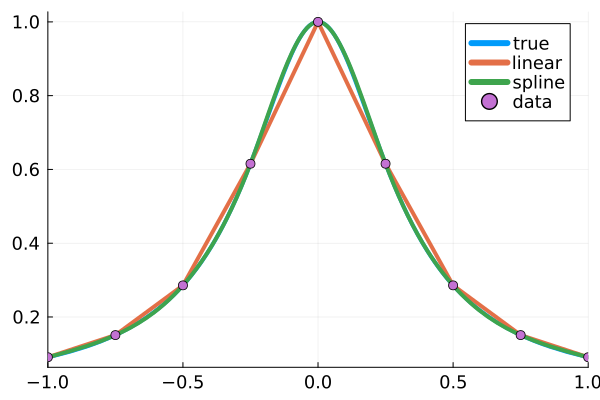

In [2]:
using Interpolations

# Let's try to fit our 'bad' function
x = LinRange(-1, 1, 9)
y = runge.(x)

# Compare linear piecewise and cubic splines
f_linear = LinearInterpolation(x, y)
f_spline = CubicSplineInterpolation(x, y)

# And compare in the "eyeball norm"
plot([runge, t->f_linear(t), t -> f_spline(t)], xlims=(-1, 1), label=["true" "linear" "spline"])
scatter!(x, y, label="data")

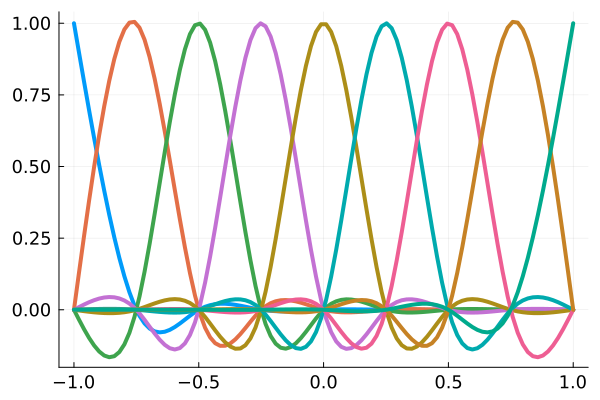

In [3]:
# Here's a matrix representation of the splines
function interp_spline(x, s)
    m, n = length(s), length(x)
    A = diagm(m, n, ones(n))
    for j in 1:n
        f_spline = CubicSplineInterpolation(x, A[1:n,j])
        A[:,j] = f_spline.(s)
    end
    A
end

# Let's plot them
s = LinRange(-1, 1, 100)
A = interp_spline(x, s)
plot(s, A, legend=:none)

## Spline conditioning

Let's see if our spline interpolation is well-conditioned.

In [4]:
function my_spy(A)
    cmax = norm(vec(A), Inf)
    s = max(1, ceil(120 / size(A, 1)))
    spy(A, marker=(:square, s), c=:diverging_rainbow_bgymr_45_85_c67_n256, clims=(-cmax, cmax))
end

A = interp_spline(LinRange(-1, 1, 40), s)
@show cond(A);

cond(A) = 1.5075717485062639


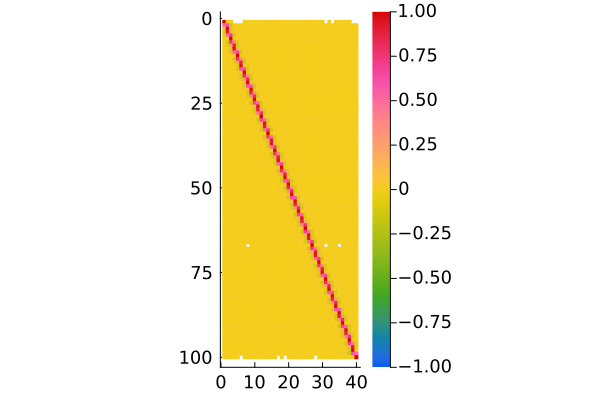

In [5]:
# Let's 'spy' the matrix A to see its structure
my_spy(A)

## Accuracy

We had these helpers before - they let us view the convergence and accuracy of our interpolating polynomials.

In [6]:
function interp_chebyshev(x, xx)
    vander_chebyshev(xx, length(x)) * inv(vander_chebyshev(x))
end

function interp_monomial(x, xx)
    vander(xx, length(x)) * inv(vander(x))
end

function interp_error(ieval, x, xx, test)
    """Compute norm of interpolation error for function test
    using method interp_and_eval from points x to points xx.
    """
    A = ieval(x, xx)
    y = test.(x)
    yy = test.(xx)
    norm(A * y - yy, Inf)
end

function plot_convergence(ievals, ptspaces; xscale=:log10, yscale=:log10, maxpts=40)
    """Plot convergence rates for an interpolation scheme applied
    to a set of tests.
    """
    xx = LinRange(-1, 1, 100)
    ns = 2:maxpts
    fig = plot(title="Convergence",
        xlabel="Number of points",
        ylabel="Interpolation error",
        xscale=xscale,
        yscale=yscale,
        legend=:bottomleft,
        size=(1200, 800))
    for ieval in ievals
        for ptspace in ptspaces
            for test in [runge]
                try
                    errors = [interp_error(ieval, ptspace(-1, 1, n), xx, test)
                             for n in ns]
                    plot!(ns, errors, marker=:circle, label="$ieval, $ptspace")
                catch
                    continue
                end
            end
        end
    end
    for k in [1, 2, 3]
        plot!(ns, ns .^ (-1.0*k), color=:black, label="\$n^{-$k}\$")
    end
    fig
end

plot_convergence (generic function with 1 method)

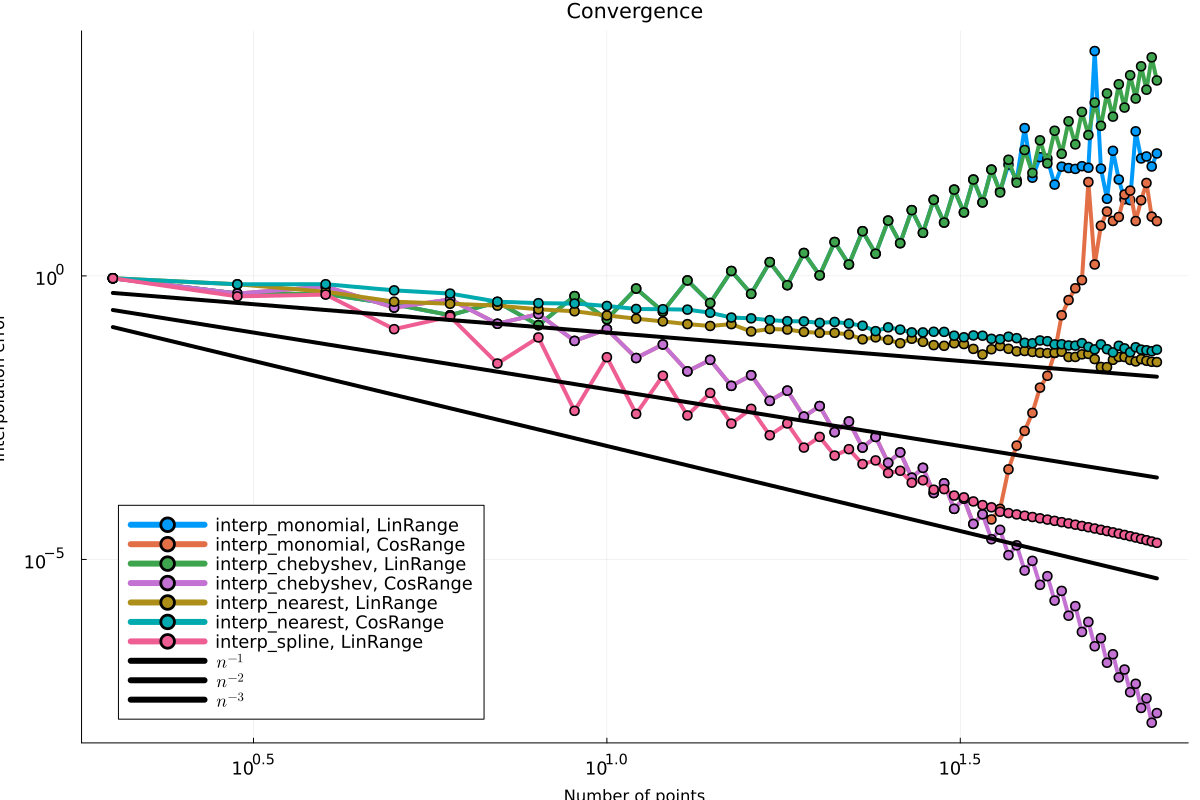

In [7]:
plot_convergence([interp_monomial, interp_chebyshev, interp_nearest, interp_spline], [LinRange, CosRange], maxpts=60)

## Generalizations of interpolation

To create a Vandermonde matrix, we choose a family of functions $\phi_j \left( x \right)$ and a set of points $x_i$, then create the matrix

$$ V_{i j} = \phi_j \left( x_i \right) $$

### Integrals?

$$ B_{i j} = \int_{\left( x_{i - 1} + x_i \right) / 2}^{\left( x_i + x_{i + 1} \right) / 2} \phi_j \left( s \right) ds $$

This leads to conservative reconstruction, which is an important part of finite volume methods, which are industry standard for shock dynamics.

### Derivatives?

What if we instead computed derivatives?

$$ A_{i j} = \phi_j ' \left( x_i \right) $$

In [8]:
function diff_monomial(x)
    n = length(x)
    A = zeros(n, n)
    A[:,2] = one.(x)
    for j in 3:n
        A[:,j] = A[:,j-1] .* x * (j - 1) / (j - 2)
    end
    A
end

diff_monomial(LinRange(-1, 1, 4))

4×4 Matrix{Float64}:
 0.0  1.0  -2.0       3.0
 0.0  1.0  -0.666667  0.333333
 0.0  1.0   0.666667  0.333333
 0.0  1.0   2.0       3.0

Hmm, that row of zeros indicates that this matrix is singular.
We need boundary conditions to make our matrix non-singular.

Let's explore this with a stable basis (Chebyshev).

In [9]:
function chebdiff(x, n=nothing)
    T = vander_chebyshev(x, n)
    m, n = size(T)
    dT = zero(T)
    dT[:,2:3] = [one.(x) 4*x]
    for j in 3:n-1
        dT[:,j+1] = j * (2 * T[:,j] + dT[:,j-1] / (j-2))
    end
    ddT = zero(T)
    ddT[:,3] .= 4
    for j in 3:n-1
        ddT[:,j+1] = j * (2 * dT[:,j] + ddT[:,j-1] / (j-2))
    end
    T, dT, ddT
end

_, dT, _ = chebdiff(LinRange(-1, 1, 4))
display(dT);

4×4 Matrix{Float64}:
 0.0  1.0  -4.0       9.0
 0.0  1.0  -1.33333  -1.66667
 0.0  1.0   1.33333  -1.66667
 0.0  1.0   4.0       9.0

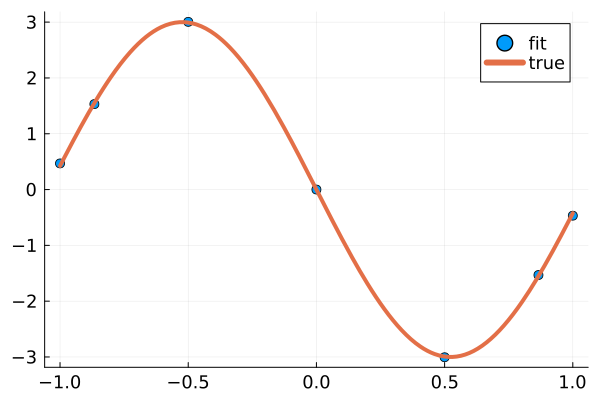

In [10]:
# We'll use the 'right' points
x = CosRange(-1, 1, 7)

# Solve for coefficients with true function
T, dT, ddT = chebdiff(x)
c = T \ cos.(3x)

# Apply fit to derivative matrix and plot
scatter(x, dT * c, label="fit")
plot!(s -> -3 * sin(3s), label="true")

## Solving BVP

A boundary value problem (BVP) asks to find a function $u \left( x \right)$ satisfying an equation like

$$ - u_{xx} \left( x \right) = f \left( x \right)$$

subject to **boundary conditions** $u \left( -1 \right) = a$ and $u' \left( 1 \right) = b$.

We'll use the *method of manufactured solutions*: choose $u \left( x \right) = \tanh \left( 2 x \right)$ and solve with the corresponding $f \left( x \right)$.
In practice, $f \left( x \right)$ comes from the physics and you need to solve for $u \left( x \right)$.

In [11]:
# Solve the Poisson problem with Chebyshev polynomials
function poisson_cheb(n, rhsfunc, leftbc=(0, zero), rightbc=(0, zero))
    x = CosRange(-1, 1, n)
    T, dT, ddT = chebdiff(x)
    L = -ddT
    rhs = rhsfunc.(x)
    for (index, deriv, func) in
            [(1, leftbc...), (n, rightbc...)]
        L[index,:] = (T, dT)[deriv+1][index,:]
        rhs[index] = func(x[index])
    end
    x, L / T, rhs
end

poisson_cheb (generic function with 3 methods)

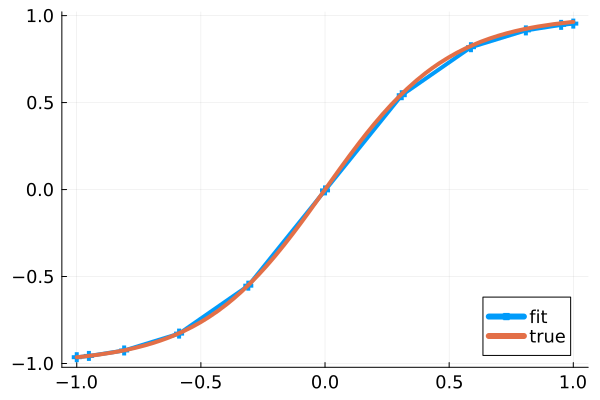

In [12]:
# Setup target functions
manufactured(x) = tanh(2x)
d_manufactured(x) = 2*cosh(2x)^-2
mdd_manufactured(x) = 8 * tanh(2x) / cosh(2x)^2

# Setup BVP problem
x, A, rhs = poisson_cheb(11, mdd_manufactured,
    (0, manufactured), (1, d_manufactured))

# Plot
plot(x, A \ rhs, marker=:auto, label="fit")
plot!(manufactured, label="true", legend=:bottomright)

### Spectral convergence

This technique shows "spectral" (exponential) convergence.

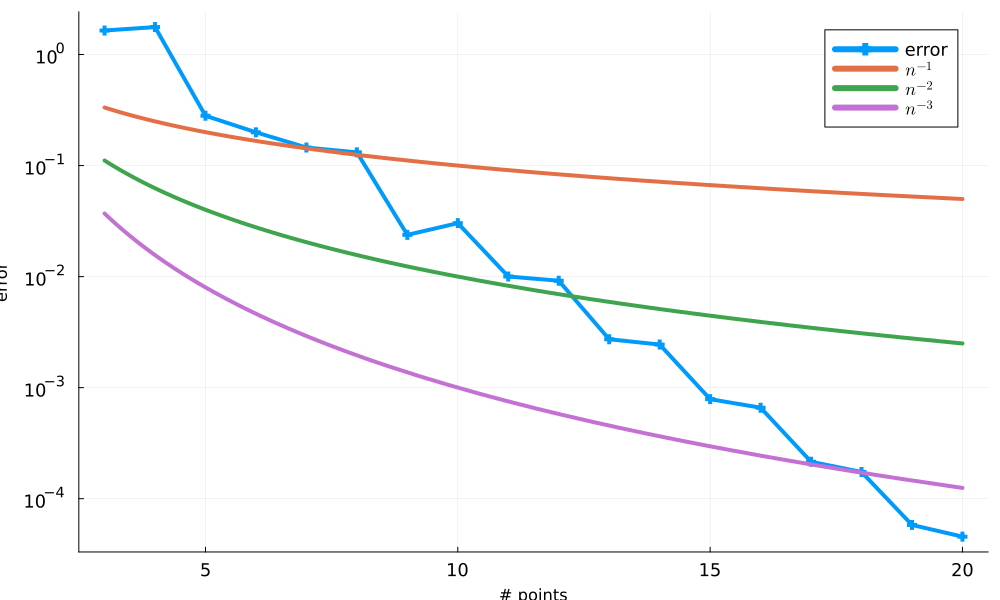

In [13]:
function poisson_error(n)
    x, A, rhs = poisson_cheb(n, mdd_manufactured, (0, manufactured), (1, d_manufactured))
    u = A \ rhs
    norm(u - manufactured.(x), Inf)
end

ns = 3:20
ps = [1 2 3]
plot(ns, abs.(poisson_error.(ns)), marker=:auto, yscale=:log10, xlabel="# points", ylabel="error", label="error")
plot!([n -> n^-p for p in ps], label=map(p -> "\$n^{-$p}\$", ps), size=(1000, 600))

## Curse of Dimensionality

Suppose we use a naive Vandermonde matrix to interpolate $n$ data points in an $n$-dimensional space of functions, e.g. predicting $z \left( x, y \right)$ from data $\left( x_i, y_i, z_i \right)$

$$ \underbrace{\Bigg[ 1 \Bigg| x \Bigg| y \Bigg| xy \Bigg| x^2 \Big| y^2 \Big| x^2 y \Big| xy^2 \Big| x^2y^2 \Big| \dotsb \Bigg]}_{V} \Bigg[ \mathbf c \Bigg] = \Bigg[ \mathbf z \Bigg] $$

Unfortunately, simply working with dense matrices of this size rapidly becomes computationally (and electricity!) expensive.

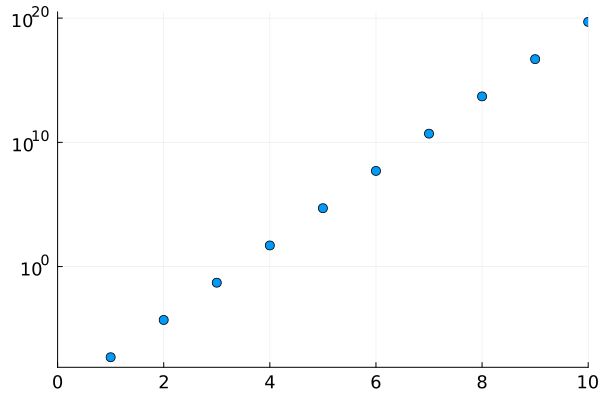

In [14]:
# A grid with 10 data points in each of d dimensions.
points(d) = 10. ^ d
flops(n) = n ^ 3
joules(flops) = flops / 20e9 # 20 GF/joule for best hardware today
scatter(1:10, d -> joules(flops(points(d))), xlims=(0, 10), yscale=:log10, legend=:none)

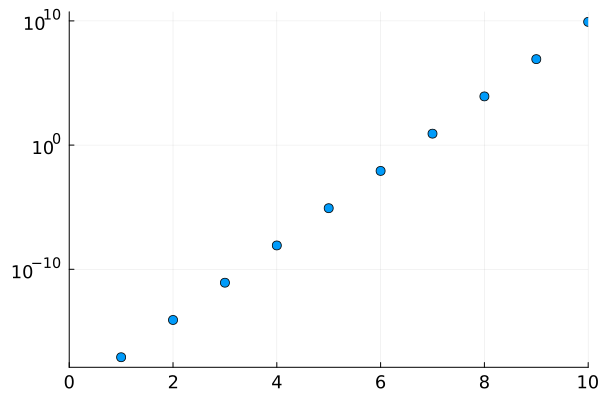

In [15]:
barrels_of_oil(flops) = joules(flops) / 6e9
scatter(1:10, d -> barrels_of_oil(flops(points(d))), xlims=(0, 10), yscale=:log10, legend=:none)

## Fourier series and tensor product structure

For periodic data on the interval $\left[ - \pi, \pi \right)$, we can use a basis $\left\lbrace 1, \sin \left( x \right), \cos \left( x \right), \sin \left( 2 x \right), \cos \left( 2 x \right), \dots \right\rbrace$, which is equivalent to $\left\lbrace 1, e^{i x}, e^{i 2 x}, \dots \right\rbrace$ with suitable complex coefficients.

If we're given equally spaced points on the interval, the Vandermonde matrix $V$ (with suitable scaling) is unitary (like orthogonal for complex matrices) and can be applied in $\mathcal{O} \left( n \log \left( n \right) \right)$ (with small constants) using the Fast Fourier Transform.
This also works for Chebyshev polynomials sampled on `CosRange` points.

This requires far less computation.

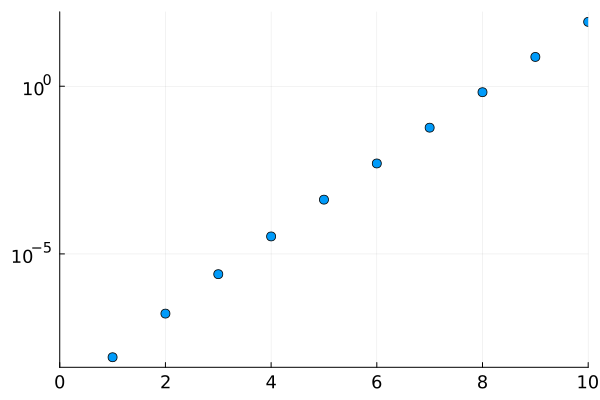

In [16]:
points(d) = 10. ^ d
flops(n) = 5n * log2(n)
joules(flops) = flops / 20e9 # 20 GF/joule for best hardware today
scatter(1:10, d -> joules(flops(points(d))), xlims=(0, 10), yscale=:log10, legend=:none)

## Partial differential equations

Boundary value problems in multiple dimensions are frequently seen in large scale computational simulations.

<video width="80" autoplay loop>
    <source src="../img/schwarz-q2-5x5x5-t20-l2-r2.webm">
</video>

## Lower-degree fitting

We can fit $m$ data points using an $n < m$ dimensional space of functions.
This involves solving a least squares problem for the coefficient $\min_c \left\lvert \left\lvert V_c - y \right\rvert \right\rvert$.

cond(V) = 30.083506637940303


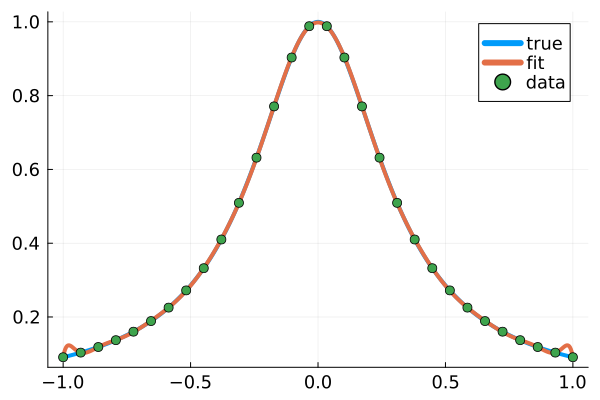

In [17]:
function chebyshev_regress_eval(x, xx, n)
    V = vander_chebyshev(x, n)
    @show cond(V)
    vander_chebyshev(xx, n) / V
end

# More data than basis functions
ndata, nbasis = 30, 20
x = LinRange(-1, 1, ndata)
xx = LinRange(-1, 1, 500)

# Fit
C = chebyshev_regress_eval(x, xx, nbasis)

# And plot
plot(xx, [runge.(xx), C * runge.(x)], label=["true" "fit"])
scatter!(x, runge, label="data")

Recall talking about truncating the SVD to fewer singular value.

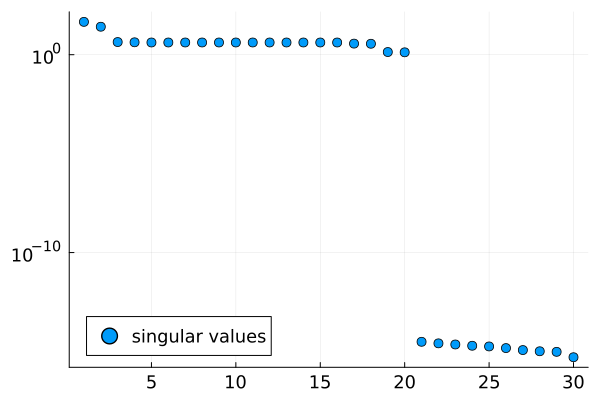

In [18]:
S = svdvals(C)
scatter(S, yscale=:log10, label="singular values", legend=:bottomleft)